In [105]:
import json
import matplotlib.pyplot as plt
import datetime
import numpy as np
import mpl_axes_aligner
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import matplotlib.ticker as ticker
from scipy.optimize import minimize
from matplotlib.ticker import FuncFormatter, MultipleLocator

In [2]:
def align_yaxis(ax1, v1, ax2, v2):
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

In [3]:
provinces=['Eastern Cape','Free State','Gauteng','KwaZulu-Natal','Limpopo','Mpumalanga','North West','Northern Cape','Western Cape']
headings=['Facilities Reporting','Admissions to Date','Died to Date','Discharged to Date','Currently Admitted','Currently in ICU','Currently Ventilated','Currently Oxygenated','Admissions in Previous Day']

<Figure size 432x288 with 0 Axes>

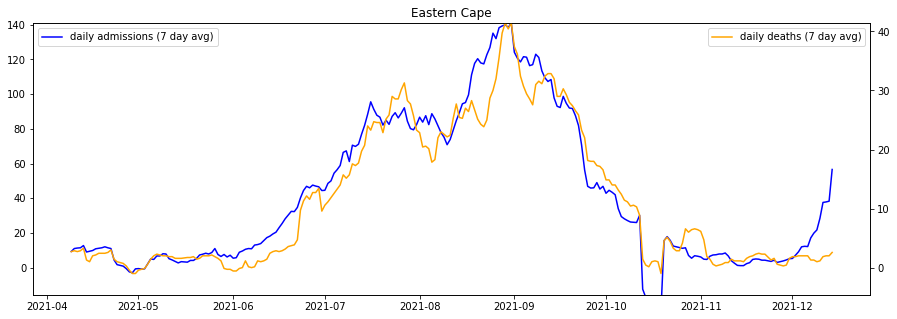

<Figure size 432x288 with 0 Axes>

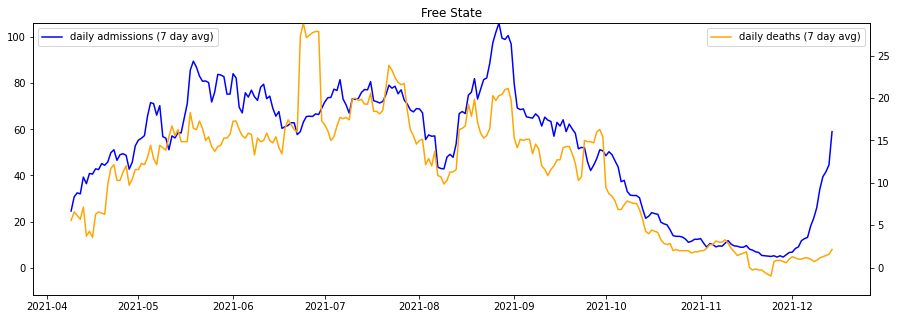

<Figure size 432x288 with 0 Axes>

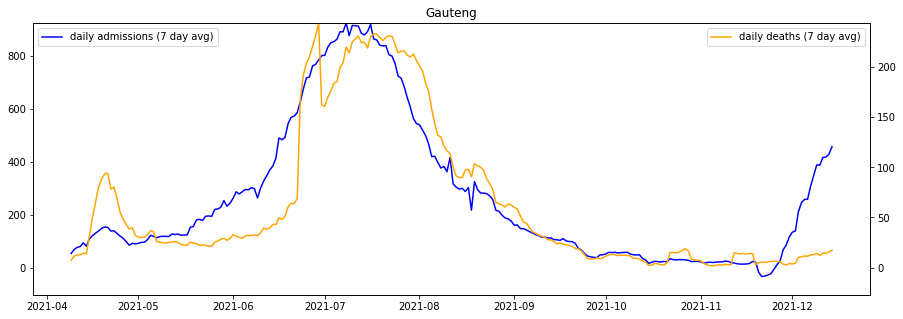

<Figure size 432x288 with 0 Axes>

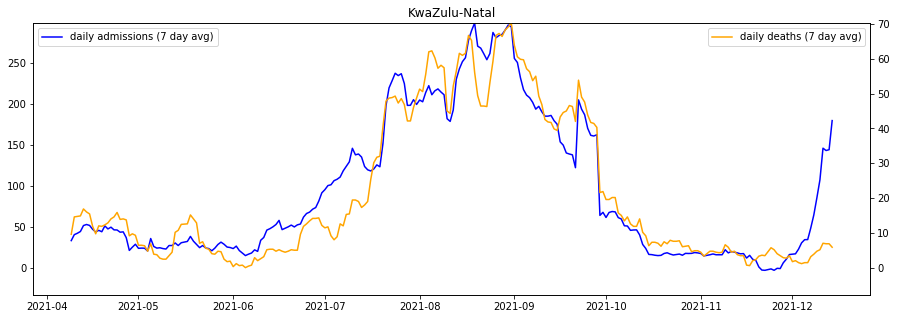

<Figure size 432x288 with 0 Axes>

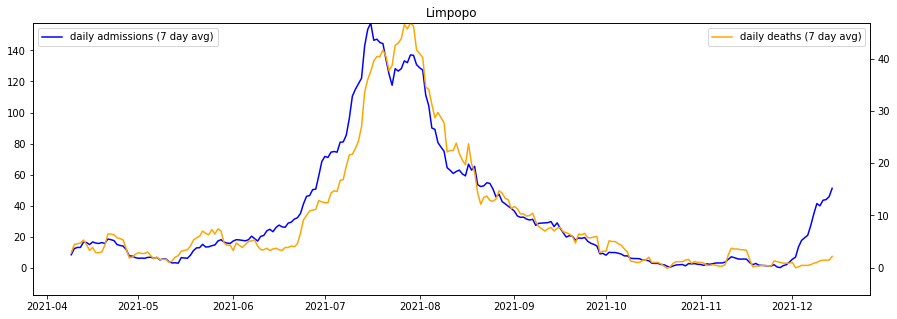

<Figure size 432x288 with 0 Axes>

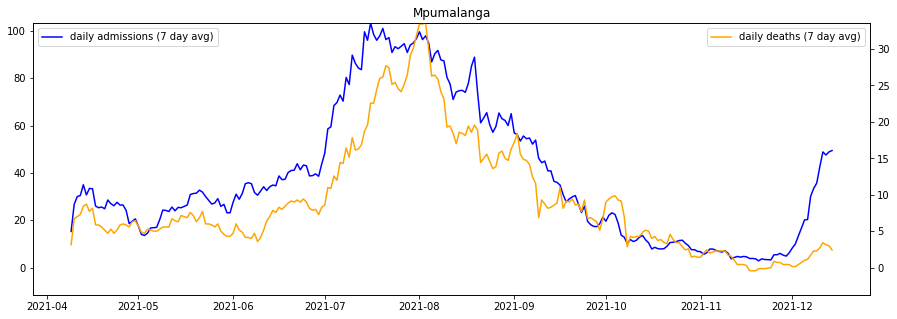

<Figure size 432x288 with 0 Axes>

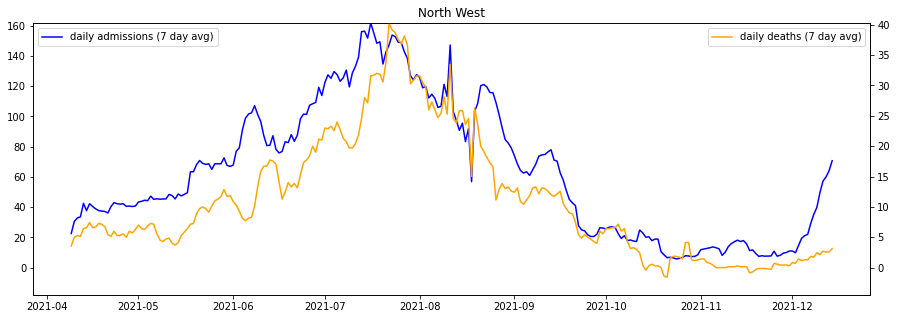

<Figure size 432x288 with 0 Axes>

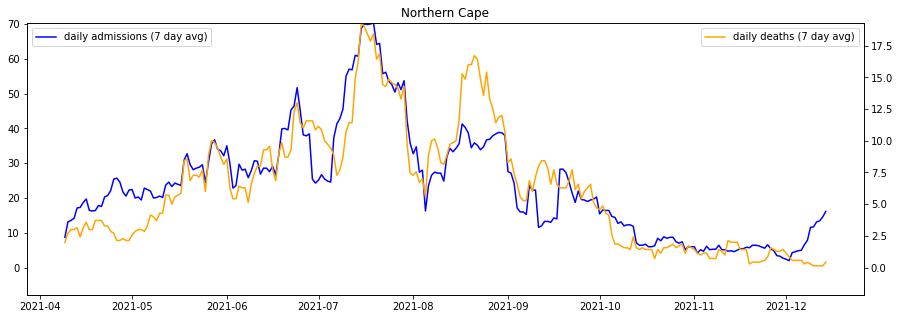

<Figure size 432x288 with 0 Axes>

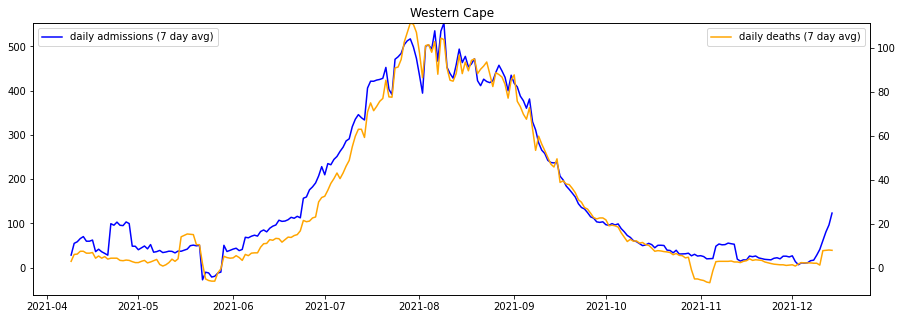

In [146]:
with open("SouthAfricaHospData.json", "r") as f:
    data = json.load(f)
    
startDate = datetime.datetime(2021, 4, 1)
endDate = datetime.datetime.now()

def N_avg(a, N=7):
    # hard edged convolution into past, preserve len(a) by nan-ing
    b = np.zeros(len(a))
    for i in range(N-1):
        b[i] = np.nan
    for i in range(N-1,len(a),1):
        b[i] = np.mean(a[i-N+1:i+1])
    return b    

xs = []
y_admiss = {}
y_died = {}

excludedDates = [
    "2020-05-25", 
    "2020-05-24", 
    "2021-11-23",
    #"2021-11-01",
    #"2021-10-14",
]

for province in provinces:
    xs = []
    _y_admiss_cum = []
    _y_died_cum = []
    for date, _d in data.items():
        if date in excludedDates:
            continue
        d = data[date][province]
        x_date = datetime.datetime.strptime(date, '%Y-%m-%d')
        if x_date > endDate or x_date < startDate:
            continue
        if not "Admissions in Previous Day" in d.keys():
            continue
        _y_admiss_cum.append(d["Admissions to Date"])
        _y_died_cum.append(d["Died to Date"])
        xs.append(x_date)
    
    _y_admiss = np.flip(np.diff(np.flip(_y_admiss_cum)))
    _y_died = np.flip(np.diff(np.flip(_y_died_cum)))
    
    y_admiss[province] = np.flip(N_avg(_y_admiss)[7:])
    y_died[province] = np.flip(N_avg(_y_died)[7:])
    xs = np.flip(xs)[8:]
    
    plt.clf()
    fig, ax1 = plt.subplots(1,1, figsize=(15,5))
    ax2 = ax1.twinx()
    ax1.plot(xs, y_admiss[province], label="daily admissions (7 day avg)", color="blue")
    ax2.plot(xs, y_died[province], label="daily deaths (7 day avg)", color="orange")
    plt.title(province)
    ax1.set_ylim(0, np.max(y_admiss[province]))
    ax2.set_ylim(0, np.max(y_died[province]))
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    mpl_axes_aligner.align.yaxes(ax1, 0, ax2, 0, 0.1)
    #plt.savefig(province+"_raw.png", bbox_inches='tight', facecolor='white', transparent=False)
    plt.show()

In [84]:
def cumsumflip(x):
    return np.flip(np.cumsum(np.flip(x)))

def _g(conv, in_stream, out_stream):
    target_out_stream = out_stream[len(conv)-1:]
    pred_out_stream = np.convolve(in_stream, conv, mode="valid")
    return target_out_stream, pred_out_stream

def g(convs):
    province = "Eastern Cape" # chosen for data not looking all that broken
    startDate = xs[0]
    startPos = list(xs).index(startDate)
    endDate = datetime.datetime(2021, 11, 20)
    endPos = list(xs).index(endDate)
    in_stream = y_admiss[province][startPos:endPos]  
    out_stream = y_died[province][startPos:endPos]
    ret = np.zeros(np.shape(convs)[0])
    for i in range(len(ret)):
        conv = convs[i,:]
        target_out_stream, pred_out_stream = _g(conv, in_stream, out_stream)
        ret[i] = np.linalg.norm(pred_out_stream - target_out_stream, ord=1) / len(pred_out_stream)
        ret[i] += 1e4*abs(1-np.sum(conv)) if np.sum(conv)>1 else 0
    return ret    

In [14]:
n_dim = 30
n_particles = 2000

x_max = 0.1*np.ones(n_dim)
x_min = -0.01*np.ones(n_dim)
options = {'c1': 0.3, 'c2': 0.1, 'w': 0.9}
bounds = (x_min, x_max)
#init_pos = np.array([0*x_min for i in range(n_particles)])
init_pos = None

outputs = []

for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(g, 1000, verbose=True, n_processes=11)
    outputs.append(pos)
outputs = np.array(outputs)

2021-12-11 07:54:54,058 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.3, 'c2': 0.1, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=1.86
2021-12-11 07:55:06,303 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.8584546888814573, best pos: [ 0.03720647  0.05954     0.03671471  0.01660908  0.02099239  0.02217206
  0.00987996  0.03046502  0.01307512 -0.00262661  0.00462069  0.00742913
  0.00230681 -0.00132034 -0.00699087  0.0120038   0.00717174  0.00422631
 -0.00815122 -0.00070439  0.00131798 -0.00277224 -0.00735363  0.01271122
  0.00173346 -0.00184922  0.00855888 -0.00498753 -0.00096709  0.00839523]
2021-12-11 07:55:06,313 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.3, 'c2': 0.1, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=1.85
2021-12-11 07:55:21,293 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.84555506696642

pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=1.79
2021-12-11 07:57:25,437 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.7938840252034247, best pos: [ 5.76732784e-02  1.83570856e-02  7.30189500e-02  1.60589196e-02
  3.14068963e-02  1.81310638e-02  1.39182694e-02  5.10403988e-03
 -1.63773444e-03  2.40777820e-02  3.72866532e-05  2.87655601e-03
  5.45865992e-03 -6.51291915e-03 -5.38486909e-03  1.04420678e-02
 -2.01954427e-03 -6.28657014e-03  1.10454101e-03 -3.83145632e-03
 -1.33323331e-03  1.15425742e-02  7.94755771e-03 -2.13170933e-03
 -2.81413703e-03 -3.78034371e-03  1.29096731e-03  5.57844206e-03
 -4.36334135e-03  1.40640273e-02]
2021-12-11 07:57:25,446 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.3, 'c2': 0.1, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=1.85
2021-12-11 07:57:37,462 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.8458046078028871

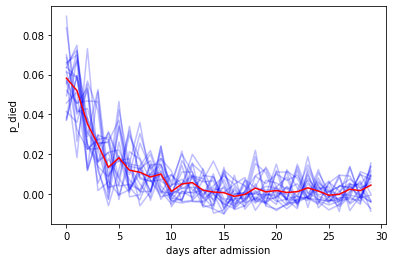

0.27899131198870847


In [147]:
plt.clf()
x = list(range(len(pos)))
for v in outputs:
    plt.plot(x, v, color="blue", alpha=0.25)
v_avg = []
for i in range(len(v)):
    v_avg.append(np.mean(outputs[:,i]))
plt.plot(x, v_avg, color="red", alpha=1)
plt.xlabel("days after admission")
plt.ylabel("p_died")
plt.savefig("convolution.png", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

print(np.sum(v_avg))

<Figure size 432x288 with 0 Axes>

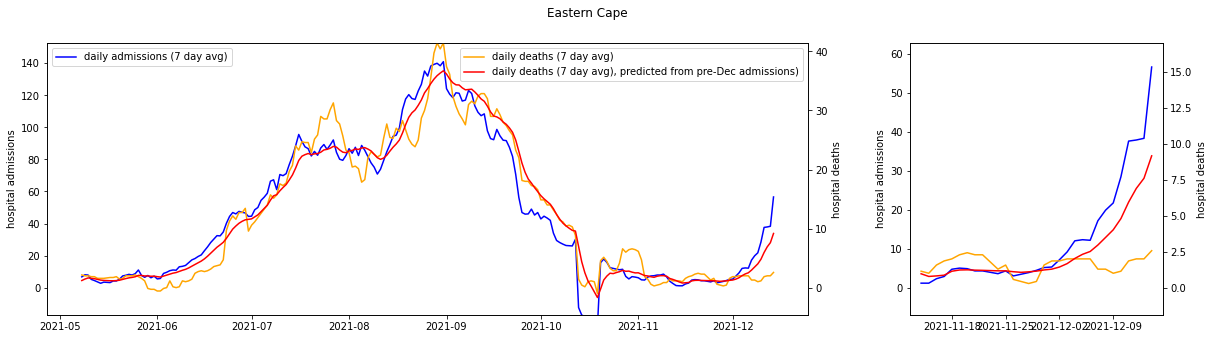

<Figure size 432x288 with 0 Axes>

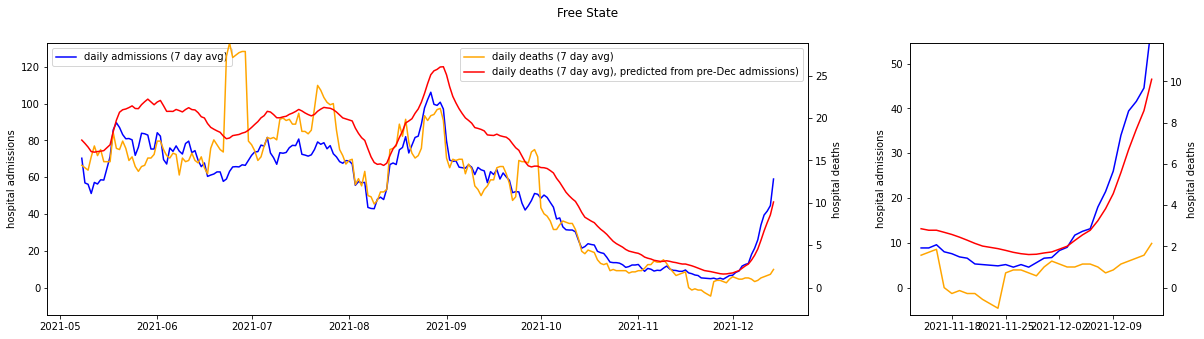

<Figure size 432x288 with 0 Axes>

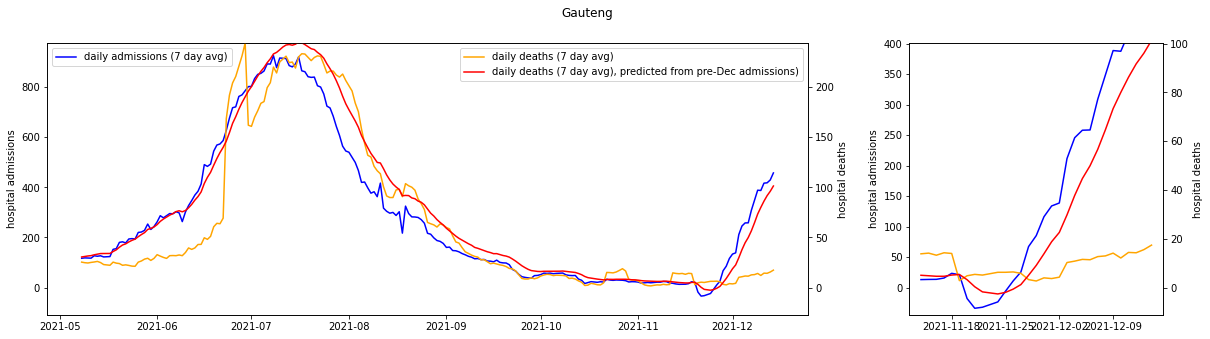

<Figure size 432x288 with 0 Axes>

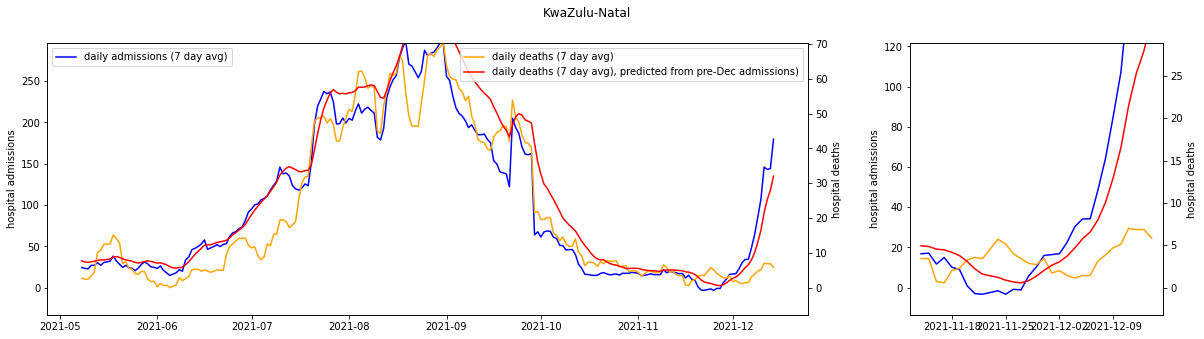

<Figure size 432x288 with 0 Axes>

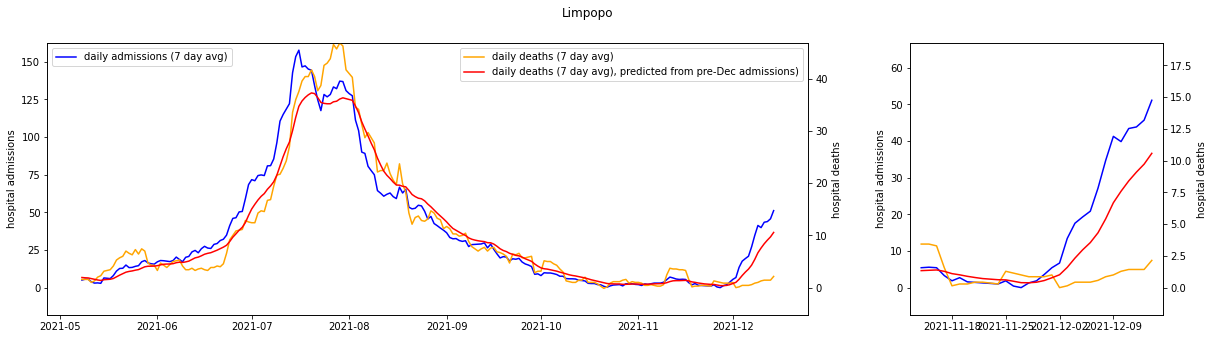

<Figure size 432x288 with 0 Axes>

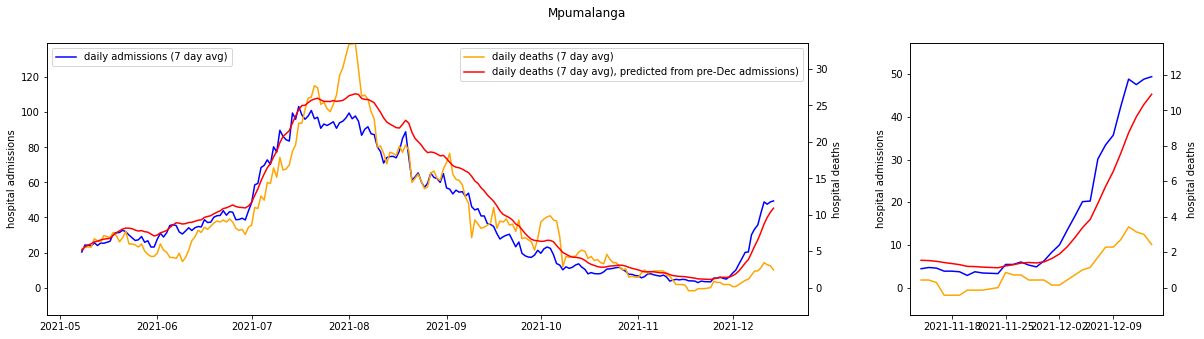

<Figure size 432x288 with 0 Axes>

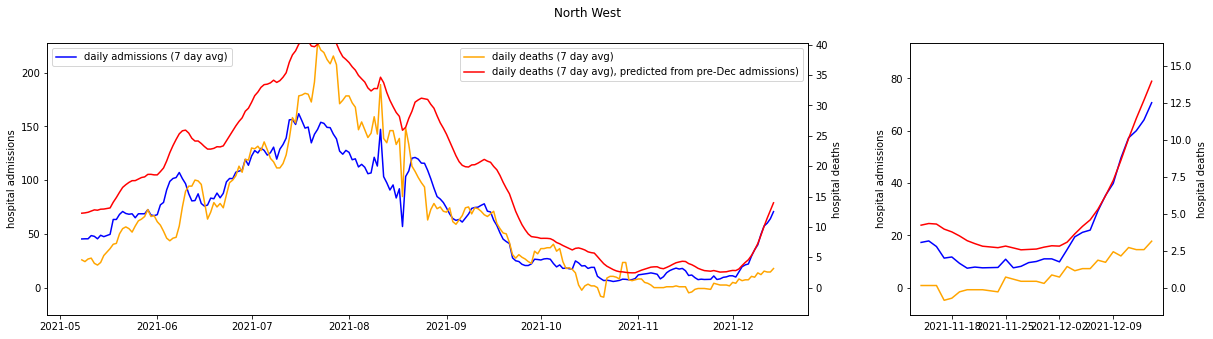

<Figure size 432x288 with 0 Axes>

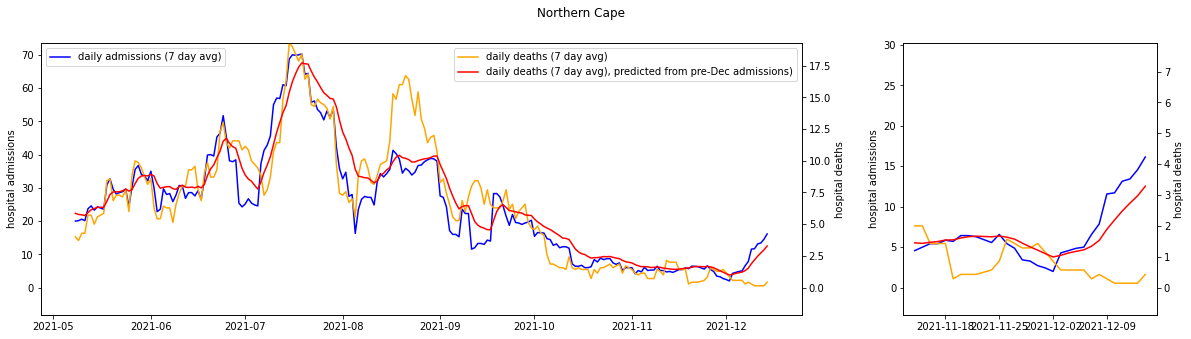

<Figure size 432x288 with 0 Axes>

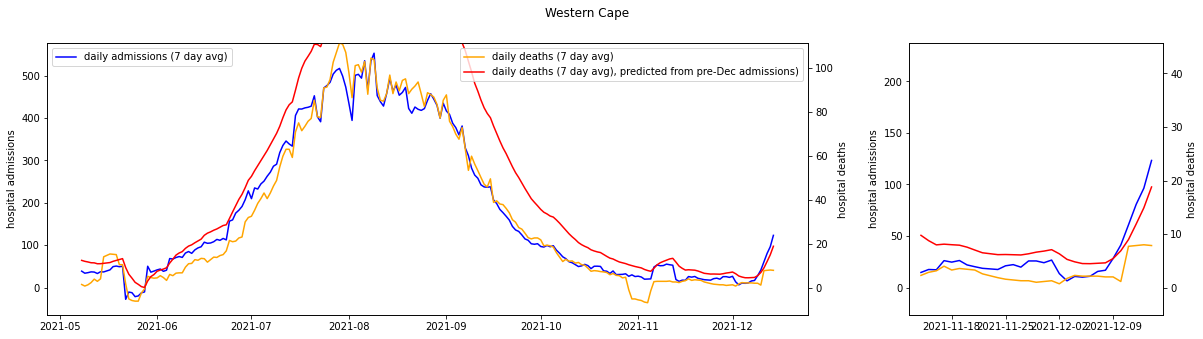

In [149]:
def diff_axis(scale, ax1, ax2):
    _,l1 = ax1.get_ylim()
    _,l2 = ax2.get_ylim()
    d1 = np.array(ax1.lines[0].get_ydata())
    d2 = np.array(ax2.lines[0].get_ydata())
    return np.mean(np.abs(d1/scale-d2))
    
def match_axis(ax1, ax2):
    scale = scipy.optimize.minimize(diff_axis, 1, args=(ax1,ax2))
    _,l2 = ax2.get_ylim()
    ax1.set_ylim(0,l2*scale.x)  
    return scale.x

for province in provinces:
    plt.clf()
    true, pred = _g(v_avg, y_admiss[province], y_died[province]) 
    x = xs[-len(true):]

    # main graph
    plt.clf()
    fig, axes = plt.subplots(1,2, figsize=(20,5), gridspec_kw={'width_ratios':[3,1]})
    ax1,ax3 = axes
    ax2 = ax1.twinx()    
    ax1.plot(x, y_admiss[province][-len(true):], label="daily admissions (7 day avg)", color="blue")
    ax2.plot(x, y_died[province][-len(true):], label="daily deaths (7 day avg)", color="orange")
    ax2.set_ylim(0,np.max(y_died[province]))
    twinScale = match_axis(ax1, ax2)
    ax2.plot(x, pred, label="daily deaths (7 day avg), predicted from pre-Dec admissions)", color="red")
    
    # zoomed in on latest
    prev_days = 30
    scale = prev_days / len(x) * 3
    ax4 = ax3.twinx()    
    ax3.plot(x[-prev_days:], y_admiss[province][-prev_days:], color="blue")
    ax4.plot(x[-prev_days:], y_died[province][-prev_days:], color="orange")
    ax4.plot(x[-prev_days:], pred[-prev_days:], color="red")
    ax4.set_ylim(0,np.max(y_died[province])*scale)
    ax3.set_ylim(0,np.max(y_died[province])*scale * twinScale)
    ax4.xaxis.set_major_locator(MultipleLocator(7)) 
    
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    ax1.set_ylabel("hospital admissions")
    ax2.set_ylabel("hospital deaths")
    ax3.set_ylabel("hospital admissions")
    ax4.set_ylabel("hospital deaths")
    
    mpl_axes_aligner.align.yaxes(ax1, 0, ax2, 0, 0.1)
    mpl_axes_aligner.align.yaxes(ax1, 0, ax3, 0, 0.1)
    mpl_axes_aligner.align.yaxes(ax1, 0, ax4, 0, 0.1)
    
    plt.suptitle(province)
    plt.savefig(province+"_pred.png", bbox_inches='tight', facecolor='white', transparent=False)
    plt.show()    
    